# 1. Comprensión de datos

In [ ]:
# Dependencias
# pip install pandas
# pip install pyarrow
# pip install numpy
# pip install matplotlib
# pip install seaborn
# pip install scikit-learn


In [28]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Preparar el data set inicial

In [20]:
# Ruta de los .parquet
DATA_PATH = "datos_examen"

# Cargar tabla principal (application)
app = pd.read_parquet(os.path.join(DATA_PATH, "application_train.parquet"))

print("\nDataset application_train cargado correctamente.")
print("Dimensiones:", app.shape)

app.head()


Dataset application_train cargado correctamente.
Dimensiones: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Descripción de los datos

In [23]:
# Mostrar dimensiones del dataset
print("Dimensiones del dataset (filas, columnas):", app.shape)

# Mostrar nombres de columnas
print("\nLista de columnas:")
for col in app.columns:
    print("-", col)

# Tipos de datos por columna
print("\nTipos de datos:")
print(app.dtypes.value_counts())

print("\nPrimeras 15 columnas con su tipo:")
print(app.dtypes.head(15))

Dimensiones del dataset (filas, columnas): (307511, 122)

Lista de columnas:
- SK_ID_CURR
- TARGET
- NAME_CONTRACT_TYPE
- CODE_GENDER
- FLAG_OWN_CAR
- FLAG_OWN_REALTY
- CNT_CHILDREN
- AMT_INCOME_TOTAL
- AMT_CREDIT
- AMT_ANNUITY
- AMT_GOODS_PRICE
- NAME_TYPE_SUITE
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- REGION_POPULATION_RELATIVE
- DAYS_BIRTH
- DAYS_EMPLOYED
- DAYS_REGISTRATION
- DAYS_ID_PUBLISH
- OWN_CAR_AGE
- FLAG_MOBIL
- FLAG_EMP_PHONE
- FLAG_WORK_PHONE
- FLAG_CONT_MOBILE
- FLAG_PHONE
- FLAG_EMAIL
- OCCUPATION_TYPE
- CNT_FAM_MEMBERS
- REGION_RATING_CLIENT
- REGION_RATING_CLIENT_W_CITY
- WEEKDAY_APPR_PROCESS_START
- HOUR_APPR_PROCESS_START
- REG_REGION_NOT_LIVE_REGION
- REG_REGION_NOT_WORK_REGION
- LIVE_REGION_NOT_WORK_REGION
- REG_CITY_NOT_LIVE_CITY
- REG_CITY_NOT_WORK_CITY
- LIVE_CITY_NOT_WORK_CITY
- ORGANIZATION_TYPE
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3
- APARTMENTS_AVG
- BASEMENTAREA_AVG
- YEARS_BEGINEXPLUATATION_AVG
- YEARS_BUIL

In [24]:
# Información general del dataset
print("\nInformación general del dataset:")
app.info()



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [25]:
# Columnas categóricas
categoricas = app.select_dtypes(include=['object']).columns
print("\nNúmero de columnas categóricas:", len(categoricas))
print("Columnas categóricas:", list(categoricas))

# Mostrar valor único de las primeras categóricas
for col in categoricas[:5]:
    print(f"\nValores únicos de la columna '{col}':")
    print(app[col].unique()[:10])  # primeros 10 para no saturar



Número de columnas categóricas: 16
Columnas categóricas: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

Valores únicos de la columna 'NAME_CONTRACT_TYPE':
['Cash loans' 'Revolving loans']

Valores únicos de la columna 'CODE_GENDER':
['M' 'F' 'XNA']

Valores únicos de la columna 'FLAG_OWN_CAR':
['N' 'Y']

Valores únicos de la columna 'FLAG_OWN_REALTY':
['Y' 'N']

Valores únicos de la columna 'NAME_TYPE_SUITE':
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' None
 'Other_B' 'Group of people']


In [ ]:
# Columnas numéricas
numericas = app.select_dtypes(include=['int64', 'float64']).columns
print("\nNúmero de columnas numéricas:", len(numericas))

print("\Resumen estadística:")
display(app[numericas].describe().T.head(10))



Número de columnas numéricas: 106

Descripción estadística rápida:


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.00000,189145.500000,278202.00000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.00000,0.000000,0.00000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.00000,0.000000,0.00000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.00000,112500.000000,147150.00000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.00000,270000.000000,513531.00000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.50000,16524.000000,24903.00000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.00000,238500.000000,450000.00000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.00029,0.010006,0.01885,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.00000,-19682.000000,-15750.00000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.00000,-2760.000000,-1213.00000,-289.000000,3.652430e+05


## Análisis inicial

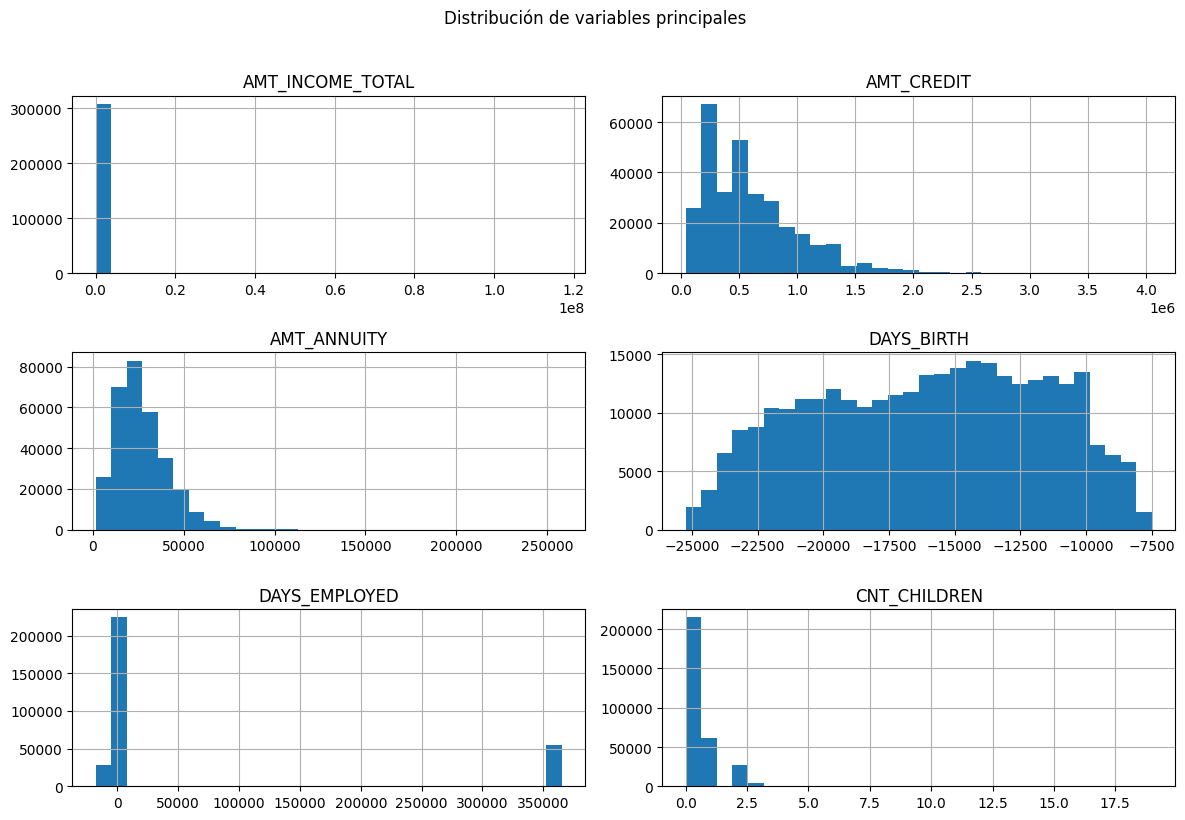

In [27]:
# Visualización de distribuciones de variables principales
vars_explorar = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "CNT_CHILDREN"
]

app[vars_explorar].hist(figsize=(12,8), bins=30)
plt.suptitle("Distribución de variables principales", y=1.02)
plt.tight_layout()
plt.show()

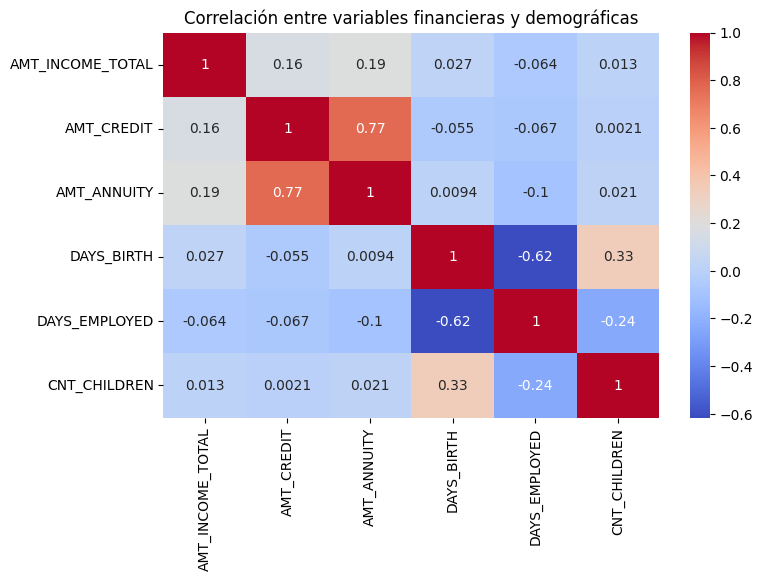

In [29]:
# Matriz de correlación
corr = app[vars_explorar].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlación entre variables financieras y demográficas")
plt.show()

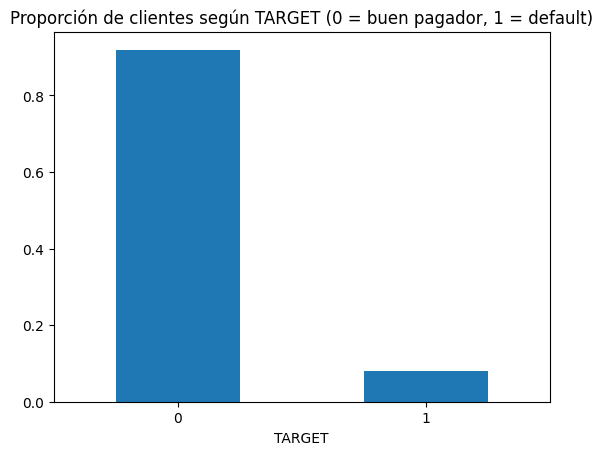

In [32]:
# Análisis de la variable TARGET
app["TARGET"].value_counts(normalize=True).plot(kind="bar")
plt.title("Proporción de clientes según TARGET (0 = buen pagador, 1 = default)")
plt.xticks(rotation=0)
plt.show()

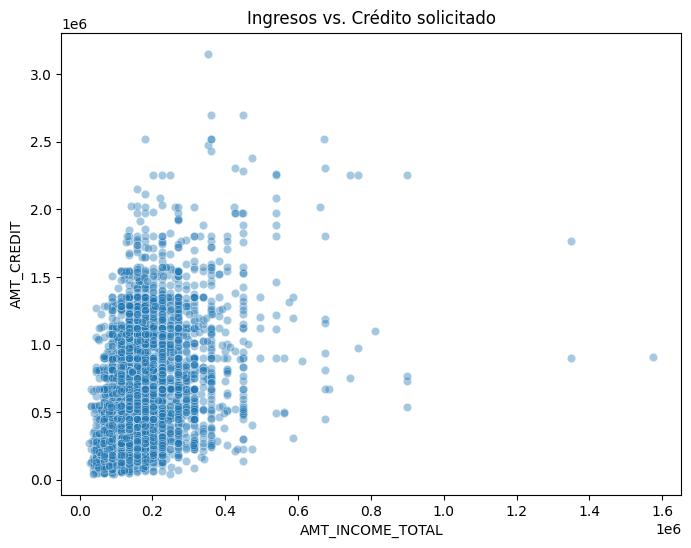

In [33]:
# Relación entre ingresos y monto de crédito solicitado
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=app.sample(5000), 
    x="AMT_INCOME_TOTAL", 
    y="AMT_CREDIT",
    alpha=0.4
)
plt.title("Ingresos vs. Crédito solicitado")
plt.show()

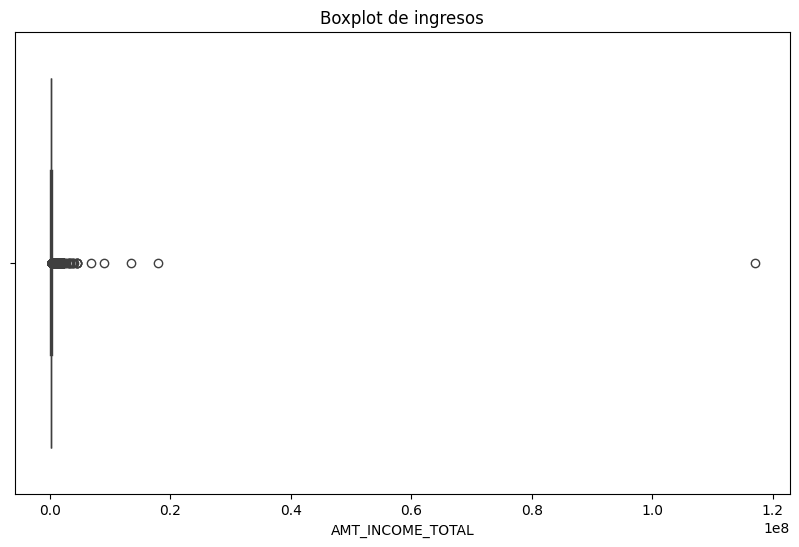

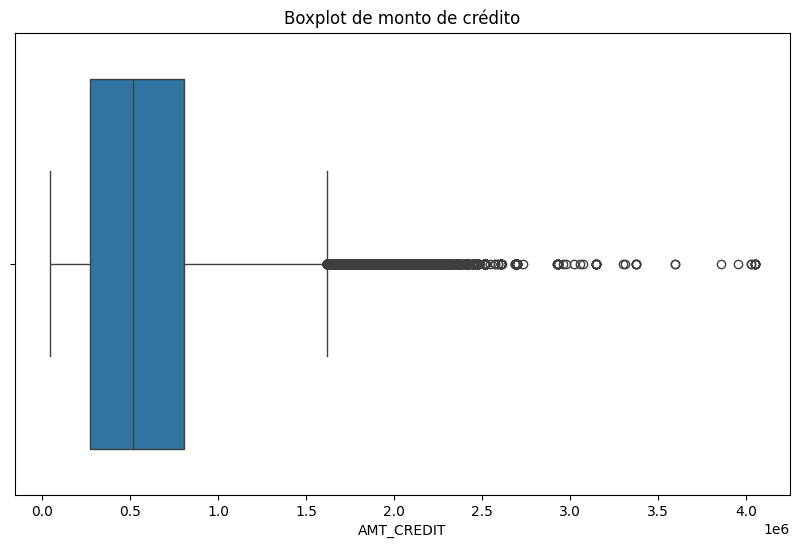

In [ ]:
# Boxplots para detectar outlierss
plt.figure(figsize=(10,6))
sns.boxplot(x=app["AMT_INCOME_TOTAL"])
plt.title("Boxplot de ingresos")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=app["AMT_CREDIT"])
plt.title("Boxplot de monto de crédito")
plt.show()

In [ ]:
# Análisis de valores únicos en DAYS_EMPLOYED

# 365243 suele representar 'no trabaja'
print("Valores únicos más comunes en DAYS_EMPLOYED:")
print(app["DAYS_EMPLOYED"].value_counts().head())

Valores únicos más comunes en DAYS_EMPLOYED:
DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64


## Calidad de los datos

In [36]:
# Calidad de los datos
nulls = app.isnull().sum().sort_values(ascending=False)
percent_nulls = (app.isnull().mean() * 100).sort_values(ascending=False)

print("Columnas con más valores nulos:")
display(pd.DataFrame({
    "Nulos": nulls,
    "% Nulos": percent_nulls
}).head(20))

Columnas con más valores nulos:


,Nulos,% Nulos
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


In [ ]:
# Columnas con más del 40% de nulo
high_nulls = percent_nulls[percent_nulls > 40]
print("Columnas con más de 40% de valores nulos:")
display(high_nulls)

Columnas con más de 40% de valores nulos:


COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
COMMONAREA_MEDI                 69.872297
NONLIVINGAPARTMENTS_MEDI        69.432963
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_AVG            68.354953
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_MODE           68.354953
FLOORSMIN_MODE                  67.848630
FLOORSMIN_AVG                   67.848630
FLOORSMIN_MEDI                  67.848630
YEARS_BUILD_AVG                 66.497784
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_MEDI                66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MEDI                   59.376738
LANDAREA_AVG                    59.376738
LANDAREA_MODE                   59.376738
BASEMENTAREA_MODE               58.515956
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
EXT_SOURCE_1                    56

In [ ]:
# Valores especiales o fuera de rango

# Revisar frecuencia del valor anómalo en DAYS_EMPLOYED
print("Valores más frecuentes en DAYS_EMPLOYED:")
print(app["DAYS_EMPLOYED"].value_counts().head())

anomalia = (app["DAYS_EMPLOYED"] == 365243).sum()
print("\nCantidad de filas con valor 365243:", anomalia)

Valores más frecuentes en DAYS_EMPLOYED:
DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64

Cantidad de filas con valor 365243: 55374


In [41]:
# Filas duplicadas
duplicates = app.duplicated().sum()
print("Número de filas duplicadas:", duplicates)

Número de filas duplicadas: 0


In [42]:
# Resumen estadístico de variables clave
vars_rango = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "CNT_CHILDREN"]

print(app[vars_rango].describe())

       AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY   CNT_CHILDREN
count      3.075110e+05  3.075110e+05  307499.000000  307511.000000
mean       1.687979e+05  5.990260e+05   27108.573909       0.417052
std        2.371231e+05  4.024908e+05   14493.737315       0.722121
min        2.565000e+04  4.500000e+04    1615.500000       0.000000
25%        1.125000e+05  2.700000e+05   16524.000000       0.000000
50%        1.471500e+05  5.135310e+05   24903.000000       0.000000
75%        2.025000e+05  8.086500e+05   34596.000000       1.000000
max        1.170000e+08  4.050000e+06  258025.500000      19.000000


In [47]:
# Valores imposibles o fuera de rango

# Edad en días -> Edad positiva en años
min_days = app["DAYS_BIRTH"].min()
max_days = app["DAYS_BIRTH"].max()

print("Rango de DAYS_BIRTH (en días):", min_days, "/", max_days)

# Convertir a años positivos
min_years = round(abs(min_days) / 365, 1)
max_years = round(abs(max_days) / 365, 1)

print("Rango de edad aproximado (en años):", min_years, "años /", max_years, "años")


Rango de DAYS_BIRTH (en días): -25229 / -7489
Rango de edad aproximado (en años): 69.1 años / 20.5 años


In [44]:
# Valores únicos en columnas categóricas
categoricas = app.select_dtypes(include=['object']).columns

for col in categoricas:
    print(f"\nColumna: {col}")
    print("Valores únicos:", app[col].unique())


Columna: NAME_CONTRACT_TYPE
Valores únicos: ['Cash loans' 'Revolving loans']

Columna: CODE_GENDER
Valores únicos: ['M' 'F' 'XNA']

Columna: FLAG_OWN_CAR
Valores únicos: ['N' 'Y']

Columna: FLAG_OWN_REALTY
Valores únicos: ['Y' 'N']

Columna: NAME_TYPE_SUITE
Valores únicos: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' None
 'Other_B' 'Group of people']

Columna: NAME_INCOME_TYPE
Valores únicos: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']

Columna: NAME_EDUCATION_TYPE
Valores únicos: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

Columna: NAME_FAMILY_STATUS
Valores únicos: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']

Columna: NAME_HOUSING_TYPE
Valores únicos: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']

Columna: OCCUPATIO

In [45]:
# Columas con un solo valor
one_value_cols = [c for c in app.columns if app[c].nunique() <= 1]
print("Columnas con un solo valor:", one_value_cols)

Columnas con un solo valor: []


In [50]:
# Resumen de problemas detectados
print("\n=== Resumen de problemas detectados ===")
print("Columnas con altos nulos:", len(high_nulls))
print("Columnas con un solo valor:", len(one_value_cols))
print("Duplicados:", duplicates)
print("DAYS_EMPLOYED anomalías:", anomalia)



=== Resumen de problemas detectados ===
Columnas con altos nulos: 49
Columnas con un solo valor: 0
Duplicados: 0
DAYS_EMPLOYED anomalías: 55374
